In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import Compose, Resize, ToTensor, Lambda
import torchvision.transforms as T
import logging
import os

import torch
import torch.nn as nn
import torch.nn.functional as F


# rest of your code


In [2]:
#!g1.1
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('data', target_types='segmentation', download=True)

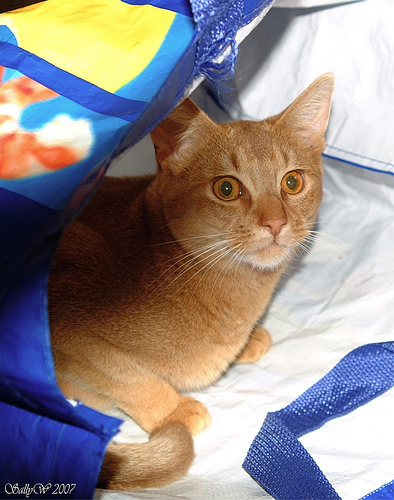

In [3]:
dataset[0][0]

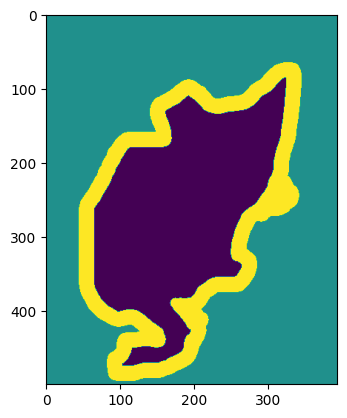

In [4]:
plt.imshow(dataset[0][1])

In [5]:
def lambda_func(x):
    return (x-1).long
    
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)
target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda_func)
    ]
)

train_dataset = OxfordIIITPet('data', transform=transform, target_transform=target_transform, target_types='segmentation', download=True)
valid_dataset = OxfordIIITPet('data', transform=transform, split='test', target_transform=target_transform, target_types='segmentation', download=True)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [7]:
train_dataset[0][0]

tensor([[[0.1373, 0.1451, 0.1451,  ..., 0.9725, 0.9725, 0.9765],
         [0.1412, 0.1451, 0.1412,  ..., 0.9843, 0.9765, 0.9804],
         [0.1451, 0.1451, 0.1412,  ..., 0.9922, 0.9882, 0.9882],
         ...,
         [0.0157, 0.0196, 0.0235,  ..., 0.2431, 0.2235, 0.2314],
         [0.0157, 0.0157, 0.0157,  ..., 0.2471, 0.2471, 0.2471],
         [0.0588, 0.0549, 0.0510,  ..., 0.2314, 0.2392, 0.2588]],

        [[0.0706, 0.0784, 0.0784,  ..., 0.9725, 0.9686, 0.9725],
         [0.0706, 0.0784, 0.0745,  ..., 0.9843, 0.9765, 0.9765],
         [0.0706, 0.0745, 0.0745,  ..., 0.9922, 0.9882, 0.9882],
         ...,
         [0.0275, 0.0314, 0.0314,  ..., 0.4118, 0.3569, 0.3490],
         [0.0235, 0.0235, 0.0235,  ..., 0.4196, 0.4157, 0.3922],
         [0.0549, 0.0510, 0.0510,  ..., 0.3725, 0.3922, 0.4235]],

        [[0.0392, 0.0471, 0.0471,  ..., 0.9882, 0.9882, 0.9922],
         [0.0392, 0.0471, 0.0431,  ..., 0.9922, 0.9882, 0.9922],
         [0.0431, 0.0431, 0.0431,  ..., 0.9961, 0.9922, 0.

In [8]:
def train(model) -> float:
    """
    Эта функция отвечает за обучение модели на данных из набора train_loader. 
    На каждой итерации происходит расчет ошибки модели и обратное распространение ошибки.
    Возвращаются средний loss и точность на данных для обучения.
    """
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    """
    Эта функция оценивает модель на валидационном наборе данных. 
    Она рассчитывает потери и точность модели на валидационных данных.
    Возвращаются средний loss и точность на валидационных данных.
    """
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

from IPython.display import clear_output
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    """
    Эта функция отображает графики потерь и точности модели на данных для обучения и валидации. 
    Отдельно выводятся графики для потерь и точности.
    """
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
@torch.inference_mode()
def visualize(model, batch):
    """
    Эта функция визуализирует результаты модели, предсказывая сегментацию на изображениях из валидационного набора данных. 
    Она выводит оригинальное изображение, маску сегментации и предсказание модели.
    """
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break
            
def whole_train_valid_cycle(model, num_epochs, title):
    """
    Эта функция производит полный цикл обучения и валидации модели. 
    Она проводит заданное количество эпох, на каждой эпохе сначала обучая модель, затем валидируя ее. 
    В процессе сохраняются истории потерь и точности, которые затем визуализируются. 
    После каждой эпохи также выводятся визуализации предсказаний модели.
    """
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 64

        # Down-convolutions
        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)

        # Up-convolutions
        self.up1 = conv_plus_conv(base_channels * 12, base_channels * 4)
        self.up2 = conv_plus_conv(base_channels * 6, base_channels * 2)
        self.up3 = conv_plus_conv(base_channels * 3, base_channels)

        # Final convolution
        self.final_conv = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Resize the input to the desired size
        x = F.interpolate(x, size=(256, 256))

        # Contracting Path
        residual1 = self.down1(x)
        x = self.downsample(residual1)

        residual2 = self.down2(x)
        x = self.downsample(residual2)

        residual3 = self.down3(x)
        x = self.downsample(residual3)

        x = self.down4(x)

        # Expansive Path
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up1(x)

        x = F.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = F.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)
        x = self.up3(x)

        # Final Convolution
        x = self.final_conv(x)

        return x


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
NVIDIA GeForce RTX 3050 Laptop GPU


In [12]:
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [13]:
from tqdm import tqdm
whole_train_valid_cycle(model, 1, 'UNET segmentation')

Train:   0%|          | 0/58 [00:00<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'builtin_function_or_method'>

In [ ]:
# Switch model to evaluation mode
model.eval()

# Evaluate the model
valid_loss, valid_accuracy = evaluate(model, valid_loader)
print(f'Validation accuracy: {valid_accuracy*100:.2f}%')

In [ ]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    predictions = []
    for x, _ in loader:
        x = x.to(device)
        outputs = model(x)
        y_pred = torch.argmax(outputs, dim=1).unsqueeze(1)  # Apply argmax over the correct dimension and add an extra dimension
        predictions.append(y_pred)
    result = torch.cat(predictions)

    return result


In [ ]:
predictions_uint8.size()

In [ ]:
predictions = predict(model, test_loader, device)

# Check the size of the predictions
print(predictions.size())  # Should be [200, 1, 256, 256]

# Save the predictions as torch.uint8
predictions_uint8 = predictions.to(torch.uint8)
torch.save(predictions_uint8, 'predictions_uint8.pth')


In [ ]:
1+1